https://github.com/seg/2016-ml-contest/blob/master/MSS_Xmas_Trees/ml_seg_try1.ipynb

In [ ]:
from numpy.fft import rfft
from scipy import signal

import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly as py


import pandas as pd
import timeit
from sqlalchemy.sql import text
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#import sherlock.filesystem as sfs
#import sherlock.database as sdb

from sklearn import preprocessing

In [ ]:
filename = 'facies_PE_ET.csv'
training_data0 = pd.read_csv(filename)
training_data0.head()

In [ ]:
correct_facies_labels = training_data0['Facies'].values

feature_vectors = training_data0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
feature_vectors.describe()

In [ ]:
scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,  correct_facies_labels, test_size=0.2, random_state=0)


In [ ]:
rf = RandomForestClassifier(max_depth = 15,n_estimators=200,max_features=None)
#rf = RandomForestClassifier()
rf.fit(X_train, y_train)

predicted_random_forest = rf.predict(X_test)

print ("prediction from random forest:")
print (metrics.accuracy_score(list(y_test), predicted_random_forest))

print ("f1 score:")
print (metrics.f1_score(list(y_test), predicted_random_forest,average = 'weighted'))

In [ ]:
training_data=training_data0.copy()

In [ ]:
temp_1=training_data.groupby('Formation').mean()
temp_2=training_data.groupby('Facies').mean()
#temp_3=training_data.groupby('Facies').count()
temp_2

In [ ]:
temp_4=training_data.groupby('Well Name')
#temp_4.describe()
#temp_5=training_data.groupby('Well Name').count()
#temp_5=training_data.groupby('Well Name').max()
temp_5=training_data.groupby('Well Name').mean()
temp_5

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Well Name,,,,,,,,,
ALEXANDER D,4.652361,3004.669528,68.280236,0.602661,6.317811,12.939109,3.777109,1.553648,0.515584
CHURCHMAN BIBLE,5.655941,3019.482673,63.683453,0.758757,1.560000,14.011116,3.789926,1.722772,0.544317
CROSS H CATTLE,3.127745,2702.360279,72.699285,0.568829,2.466667,15.574850,3.325852,1.297405,0.506182
KIMZEY A,4.820046,3028.063781,53.334339,0.840528,8.515380,11.490460,3.996795,1.615034,0.539453
LUKE G U,4.353579,2725.708243,64.777223,0.639690,4.218438,12.953905,3.660705,1.466377,0.514095
NEWBY,4.801296,2941.500000,60.733045,0.674812,3.477970,11.625378,3.771706,1.615551,0.528138
NOLAN,4.643373,2957.000000,68.693940,0.592400,3.134070,12.197361,3.857947,1.527711,0.549007
Recruit F9,9.000000,3038.012500,43.355063,0.600650,2.205925,12.700106,5.298384,2.000000,0.462425
SHANKLE,3.576837,2890.502227,65.431180,0.630831,2.348998,15.741125,3.224944,1.340757,0.503118


In [ ]:
xx0 = list(training_data0.Facies)
#xx1 = list(training_data0.DeltaPHI)
xx1 = list(training_data0.GR)

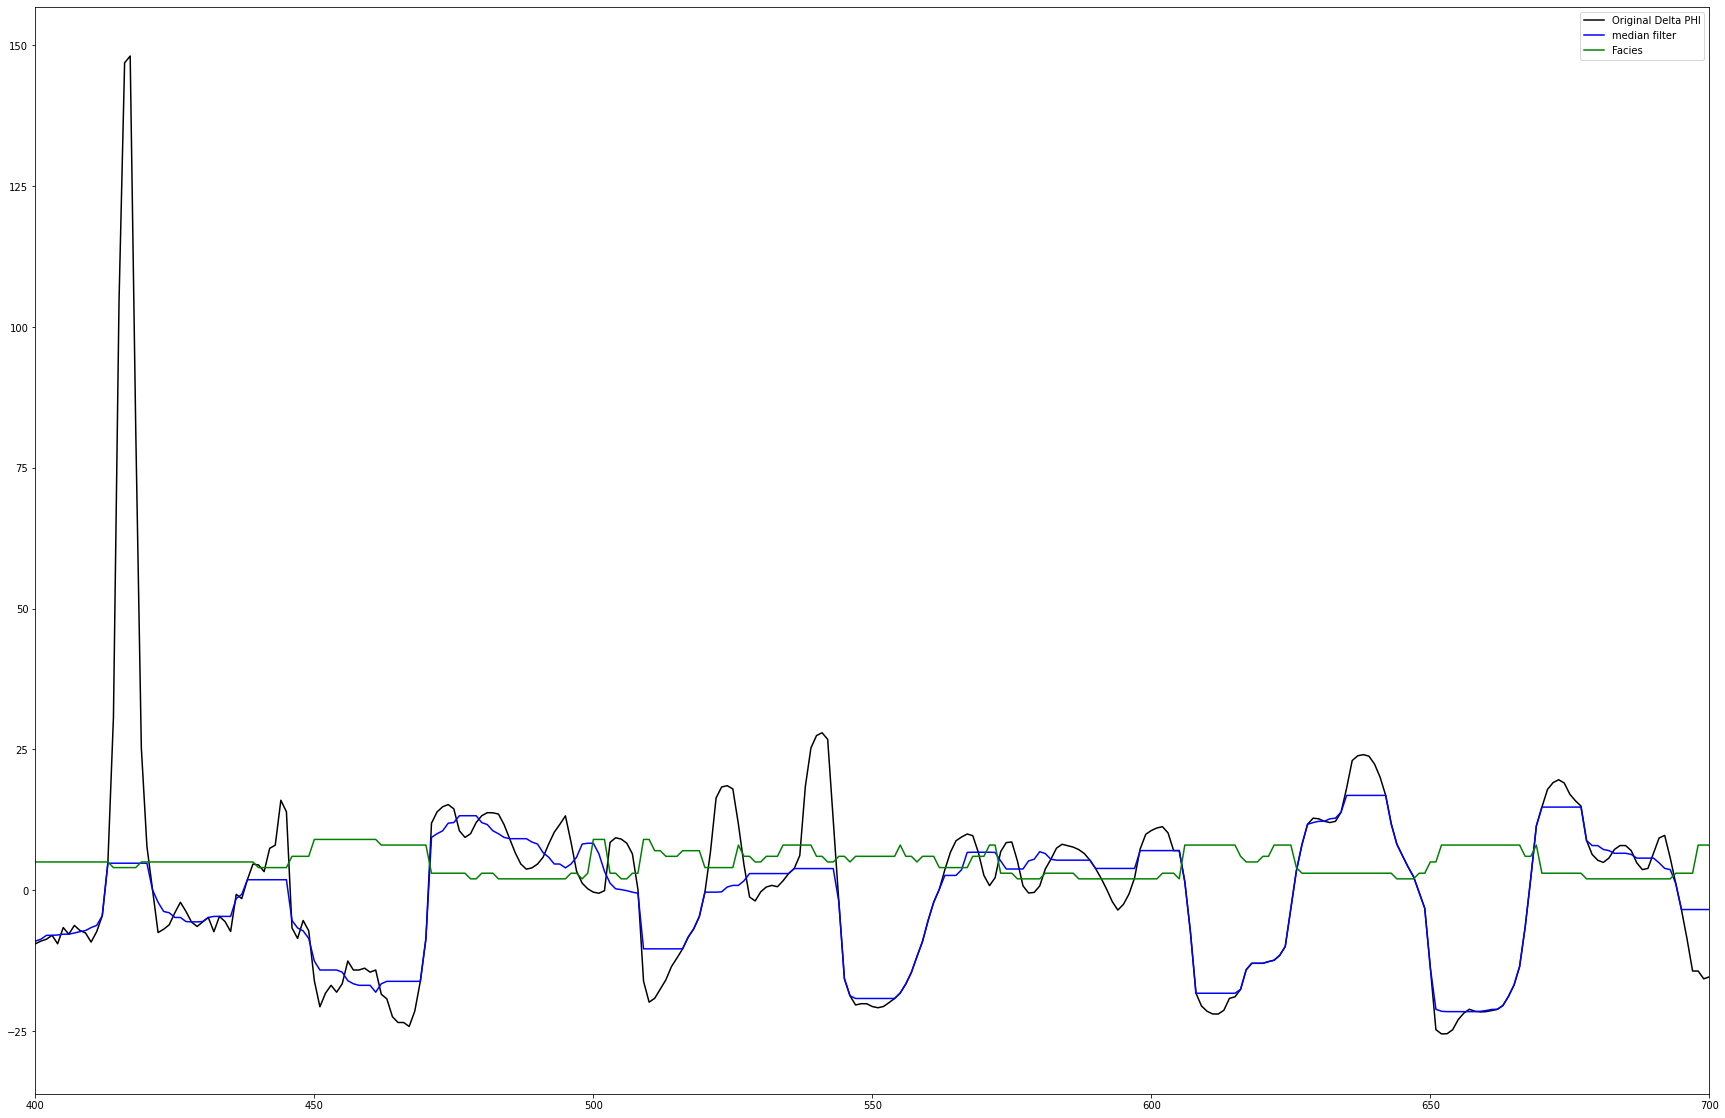

In [ ]:
x_min1=np.roll(xx1, 1)
x_min2=np.roll(xx1, 2)
x_min3=np.roll(xx1, 3)
scale=0.5
#b, a = signal.butter(2, 0.125, analog=False)
b, a = signal.butter(2, 0.09, btype='low', analog=False)
b, a = signal.butter(2, 0.2, btype='high', analog=False)

xx1=xx1-np.mean(xx1) 
xx_fil = signal.filtfilt(b, a, xx1)
xx_mf= signal.medfilt(xx1,15)

xx_grad=np.gradient(xx1)

fig, ax = plt.subplots(figsize=(30, 20))

plt.plot(scale*xx1, color='black', label='Original Delta PHI')

#plt.plot(scale*xx_grad, color='blue', label='derivative')
#plt.plot(scale*xx_fil, color='red', label='low pass filter')
#plt.plot(scale*xx_fil, color='red', label='high pass filter')
plt.plot(scale*xx_mf, color='blue', label='median filter')
#plt.plot(x_min1, color='yellow', label='1 sample shift')
#xlim([500 800])
plt.plot(xx0, color='green', label='Facies')
ax.set_xlim(400,700)
#plt.plot(sig_lf, color='#cc0000', label='lfilter')
plt.legend(loc="best")
plt.show()


In [ ]:
def magic(df):
    df1=df.copy()
    b, a = signal.butter(2, 0.2, btype='high', analog=False)
    feats00=['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
    feats01=['GR','DeltaPHI','PHIND']
    for ii in feats00:
        df1[ii]=df[ii]
        name1=ii + '_1'
        name2=ii + '_2'
        name3=ii + '_3'
        name4=ii + '_4'
        xx1 = list(df[ii])
        xx_mf= signal.medfilt(xx1,9)
        x_min3=np.roll(xx_mf, 3)    
        xx1a=xx1-np.mean(xx1)
        xx_fil = signal.filtfilt(b, a, xx1)
        xx_grad=np.gradient(xx1a) 
        if ii in feats01: 
            df1[name1]=x_min3
            df1[name2]=xx_fil
            df1[name3]=xx_grad
            df1[name4]=xx_mf     
    return df1


In [ ]:
#del training_data1
df=training_data0.copy()
training_data1=magic(df)

7
7


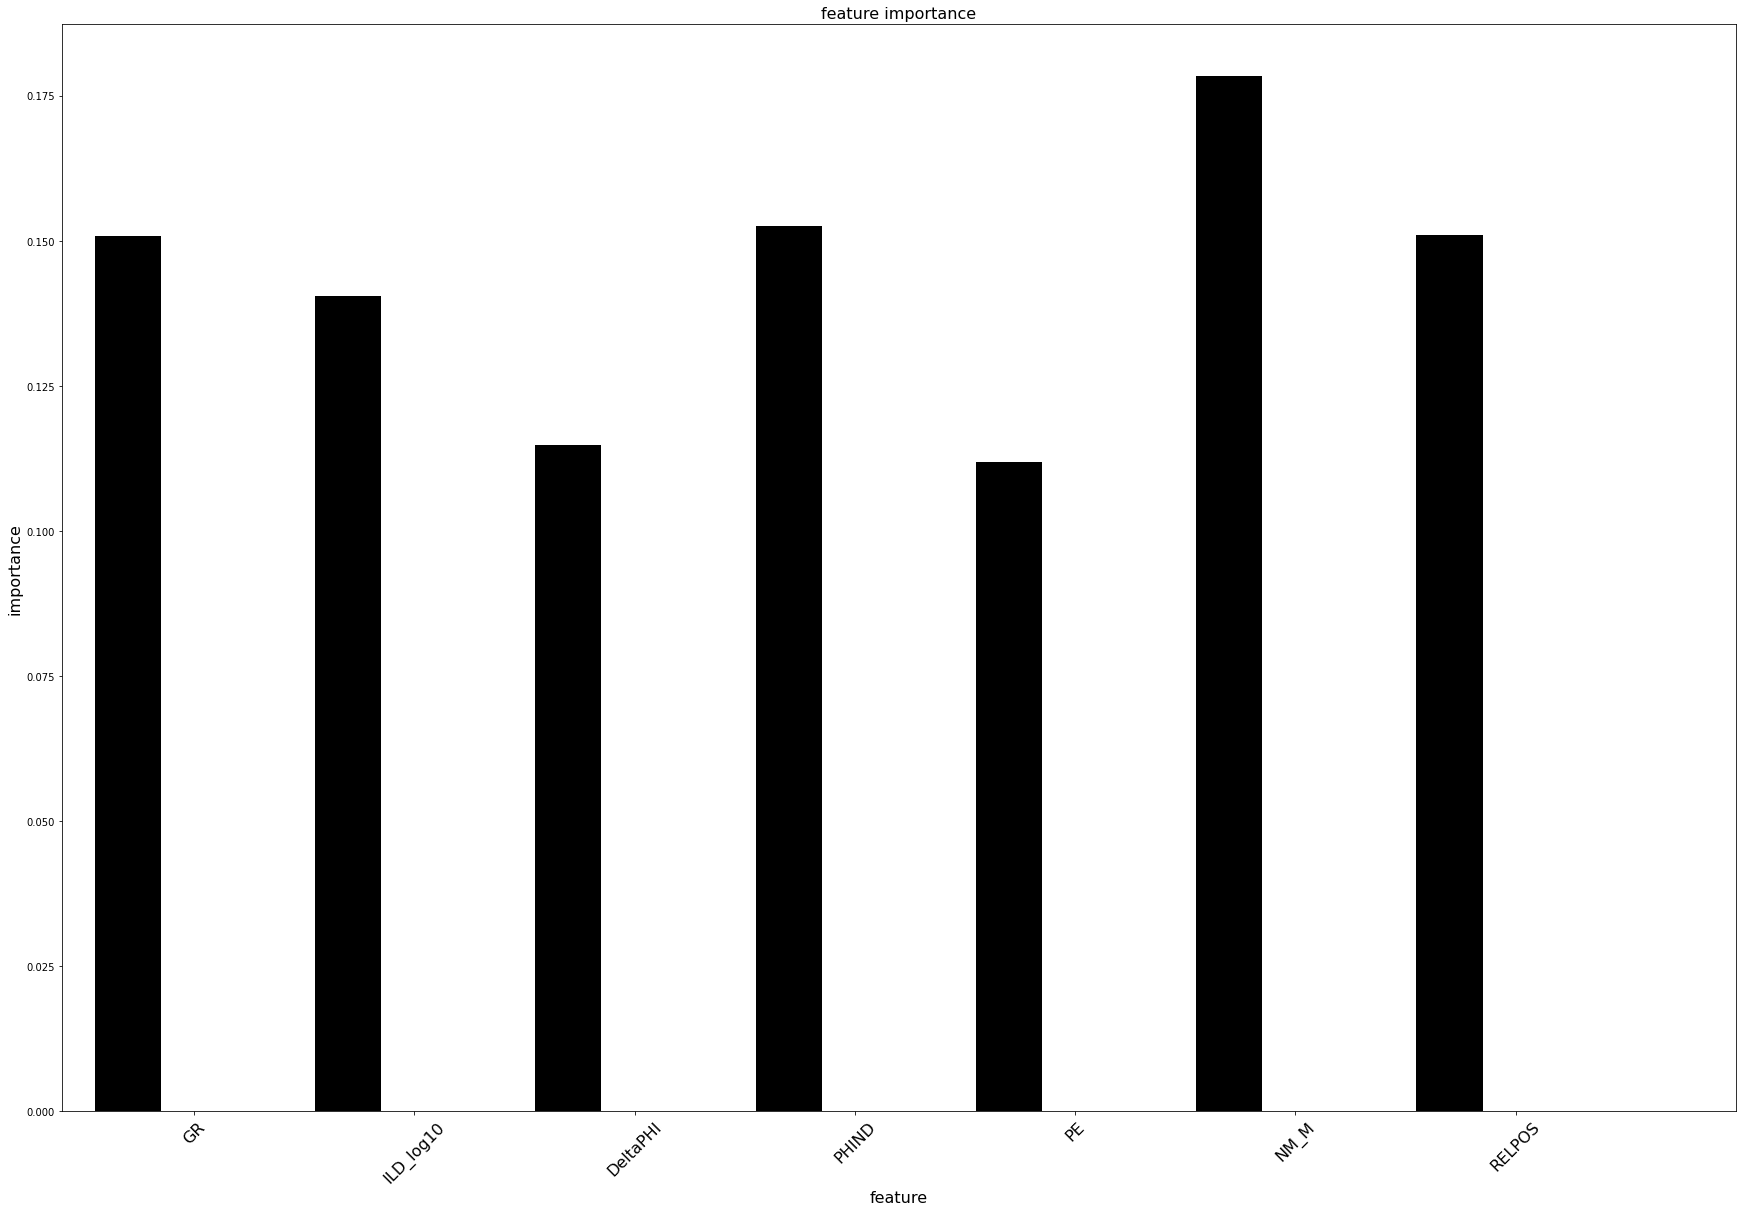

In [ ]:
x=rf.feature_importances_
kolummen = feature_vectors.columns.tolist()
mask=x>0.025
mask=x>0.035
#mask=x>0.025
x1=x[mask]

#kols=kolummen[mask]
kols=[]
kols_out=[]
count=0
for name in kolummen:
    if mask[count]==True:
        kols.append(name)
    else:
        kols_out.append(name)
    count+=1        
fig, ax = plt.subplots(figsize=(30, 20))


## the data
N = len(kols)
#N = len(kolummen)-18

#X=gradboost.feature_importances_
#X=rf.feature_importances_
X=x1

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.30                      # the width of the bars
fsize=16
## the bars
rects1 = ax.bar(ind, X, width,
                color='black')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
#ax.set_ylim(0,45)
ax.set_xlabel('feature', fontsize=fsize)
ax.set_ylabel('importance', fontsize=fsize)
ax.set_title('feature importance', fontsize=fsize)
#xTickMarks = ['Group'+str(i) for i in range(1,6)]
xTickMarks = kols
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks, fontsize=fsize)
plt.setp(xtickNames, rotation=45, fontsize=fsize)

## add a legend
#ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )
print (count)
print (N)
plt.show()

In [ ]:
training_data1a = training_data1.drop(kols_out, axis=1)
training_data1a.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,GR_1,GR_2,GR_3,GR_4,DeltaPHI_1,DeltaPHI_2,DeltaPHI_3,DeltaPHI_4,PHIND_1,PHIND_2,PHIND_3,PHIND_4
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,49.594,-0.013419,0.810,74.58,1.828,-0.001270,4.30,9.9,7.254,-0.006415,0.6500,11.915
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,46.719,0.005020,0.800,74.58,1.828,2.592465,2.45,13.5,7.149,0.188713,0.5675,12.565
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,44.563,0.404089,3.920,74.58,1.828,1.802692,-0.15,13.9,6.668,0.263665,0.2750,13.050
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,74.580,7.759225,-2.235,75.65,9.900,-0.068553,-0.65,14.0,11.915,-0.010605,0.1250,13.115
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,74.580,-2.805883,-6.065,75.65,13.500,-1.139593,0.05,14.2,12.565,-0.092611,0.1350,13.300
